### Info
- This little project explores results from this A/B test [dataset](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing/), exploring the data, deciding which test to use, and seeing whether to accept or reject the null hypothesis (that the test group had no difference vs the control group).
- Null hypothesis: that users seeing `ad` converted no differently vs users that saw `psa`
- A lot of inspiration taken from this notebook: https://www.kaggle.com/code/babyoda/a-b-testing-in-practicehttps://www.kaggle.com/code/babyoda/a-b-testing-in-practice

Data dictionary:

* Index: Row index
* user id: User ID (unique)
* test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
* converted: If a person bought the product then True, else is False
* total ads: Amount of ads seen by person
* most ads day: Day that the person saw the biggest amount of ads
* most ads hour: Hour of day that the person saw the biggest amount of adsData dictionary:

In [1]:
#Definition of the Necesarry Modules
import statistics
import pandas as pd
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/marketing-ab-testing/marketing_AB.csv


In [2]:
df=pd.read_csv('/kaggle/input/marketing-ab-testing/marketing_AB.csv')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [4]:
df.describe()

,Unnamed: 0,user id,total ads,most ads hour
count,588101.000000,5.881010e+05,588101.000000,588101.000000
mean,294050.000000,1.310692e+06,24.820876,14.469061
std,169770.279668,2.022260e+05,43.715181,4.834634
min,0.000000,9.000000e+05,1.000000,0.000000
25%,147025.000000,1.143190e+06,4.000000,11.000000
50%,294050.000000,1.313725e+06,13.000000,14.000000
75%,441075.000000,1.484088e+06,27.000000,18.000000
max,588100.000000,1.654483e+06,2065.000000,23.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [10]:
def summarize(data):
    print(df.shape)
    summ = pd.DataFrame(data.dtypes, columns=['data type'])
    
    summ['#missing'] = data.isnull().sum()
    summ['%missing'] = data.isnull().sum() / len(data)
    summ['#unique'] = data.nunique()
    summ['max'] = data.max()
    summ['min'] = data.min()
    
    return summ

summarize(df)

(588101, 7)


,data type,#missing,%missing,#unique,max,min
Unnamed: 0,int64,0,0.0,588101,588100,0
user id,int64,0,0.0,588101,1654483,900000
test group,object,0,0.0,2,psa,ad
converted,bool,0,0.0,2,True,False
total ads,int64,0,0.0,807,2065,1
most ads day,object,0,0.0,7,Wednesday,Friday
most ads hour,int64,0,0.0,24,23,0


In [ ]:
## correlations

df.drop()

### EDA

In [11]:
#Convert 'most ads day' into numerical column

# Create a dictionary that maps days of the week to numbers
days = {
    'Monday': 1, 
    'Tuesday': 2, 
    'Wednesday': 3, 
    'Thursday': 4, 
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

# Use the map() function to change the 'day' column
df['day'] = df['most ads day'].map(days)

In [12]:
df_test = df[df['test group'] == 'ad']
df_control = df[df['test group'] == 'psa']

In [4]:
print("Test records: "+str(len(df_test)),"\n")
print("Control records: "+str(len(df_control)),"\n")

Test records: 564577 

Control records: 23524 



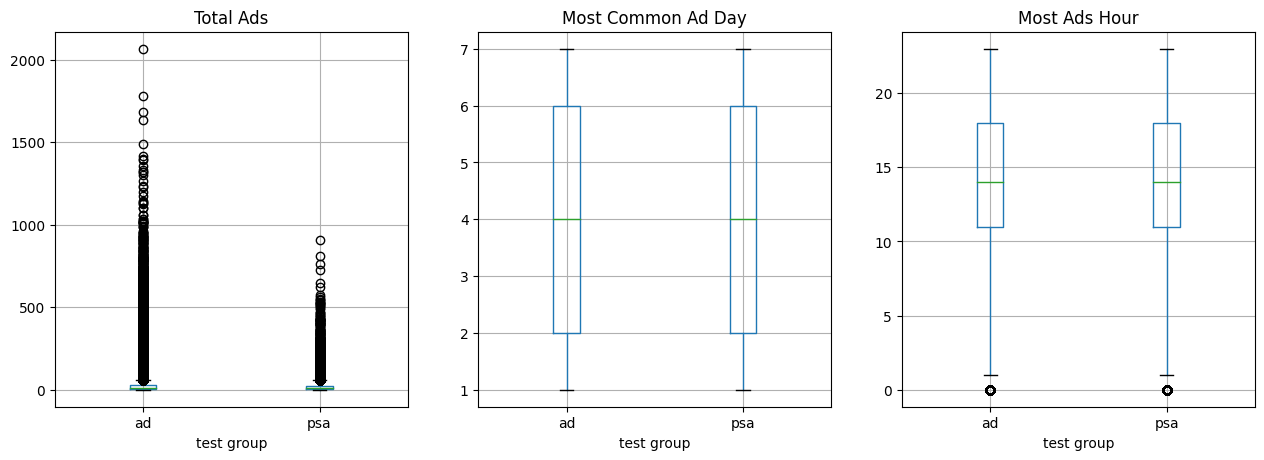

In [13]:
# create a new figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# generate the boxplots
df.boxplot(column='total ads', by='test group', ax=axes[0])
df.boxplot(column='day', by='test group', ax=axes[1])
df.boxplot(column='most ads hour', by='test group', ax=axes[2])

# set the titles
axes[0].set_title('Total Ads')
axes[1].set_title('Most Common Ad Day')
axes[2].set_title('Most Ads Hour')

# remove automatic title
plt.suptitle('')

# display the plot
plt.show()

/tmp/ipykernel_43/2009779333.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['test group']=='ad', color="skyblue", label="testgroup_ad")
/tmp/ipykernel_43/2009779333.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['test group']=='psa', color="red", label="controlgroup_psa")


<Axes: xlabel='test group', ylabel='Density'>

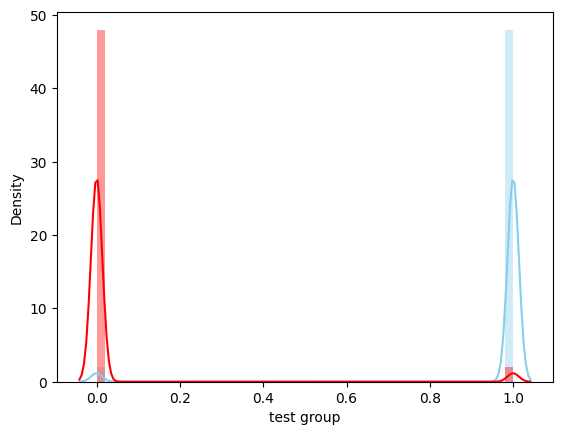

In [11]:
sns.distplot(df['test group']=='ad', color="skyblue", label="testgroup_ad")
sns.distplot(df['test group']=='psa', color="red", label="controlgroup_psa")

### Testing for normalcy (Shapiro test) and homogenity (Levene test)

In [8]:
variables = ["total ads","day","most ads hour"]
target = ['converted']

for x in target:
    test_shaphiro_w, test_shaphiro_p = shapiro(df_test[x])
    control_shaphiro_w, control_shaphiro_p = shapiro(df_control[x])

    print("test_shaphiro_p = %.3f, control_shaphiro_p = %.3f" % (test_shaphiro_p, control_shaphiro_p),"\n")

test_shaphiro_p = 0.000, control_shaphiro_p = 0.000 



/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro test pvalues are <0.05 for both Test and Control groups; reject the null hypothesis. Test and Control do not have normal distributions of these variables.

In [10]:
for x in variables:
    levene_F, levene_p = stats.levene(df_test[x], df_control[x])
    print(x+": levene_F = %.3f, levene_p = %.3f" % (levene_F, levene_p),"\n")       

total ads: levene_F = 5.358, levene_p = 0.021 



KeyError: 'day'

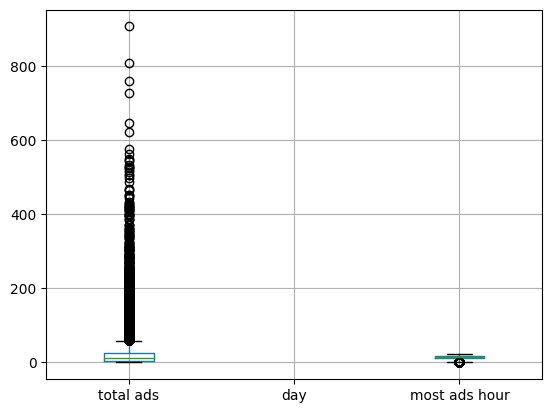

In [11]:
levene_viz = pd.DataFrame(df_control, columns = variables)

levene_viz.boxplot()
plt.show()

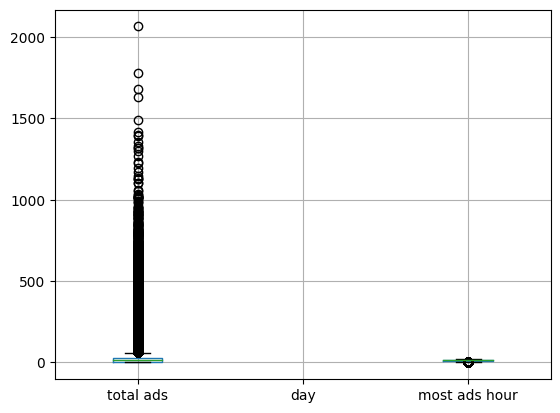

In [12]:
levene_viz_test = pd.DataFrame(df_test, columns = variables)

levene_viz_test.boxplot()
plt.show()

Shapiro test pvalues are <0.05 for both Test and Control groups; reject the null hypothesis. Test and Control do not have normal distributions of these variables.

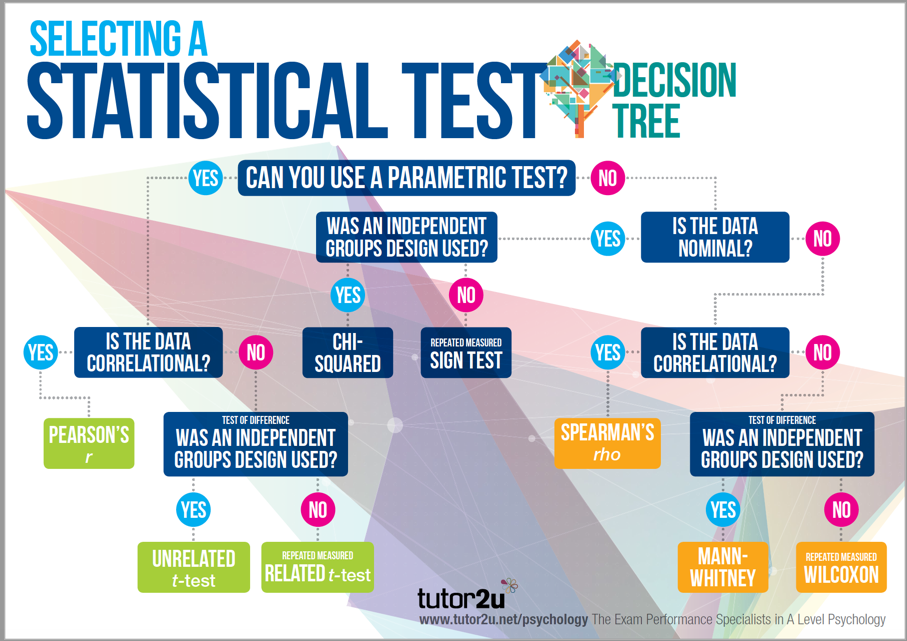

## Mann Whitney U Test

In [3]:
from scipy.stats import mannwhitneyu

u_value, mannw_test_p = mannwhitneyu(df_test['converted'], df_control['converted'])

print('u_value=%.3f, mannw_test_p=%.3f' % (u_value, mannw_test_p), "\n")

if mannw_test_p > 0.05:
    print("Mann Whitney U Test resulted in p > .05 which means H0 isn't rejected.", "\n")
else:
    print("Mann Whitney U Test resulted in p < .05 which means H0 IS rejected; there is a difference between test and control.", "\n")

NameError: name 'df_test' is not defined